## Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Lasso

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [3]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

### Undersampling majority class: Random Undersampling

In [4]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


### Oversampling minority class: SMOTE-NC

In [5]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-hot encoding (for random forest)

In [6]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Feature selection

##### SelectKBest

In [8]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = selector.fit_transform(X_train_ohe,y_train_smote)
X_test_kbest = selector.transform(X_test_ohe)

##### Lasso

In [9]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_ohe, y_train_smote)
feature_importance = pd.Series(lasso.coef_, index=X_train_ohe.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()
X_train_lasso = X_train_ohe.loc[:, selected_features]
X_test_lasso = X_test_ohe.loc[:, selected_features]

##### RFECV

In [24]:
# Run RFECV with step = 0.1 first to narrow down to a rough figure
cv_split = StratifiedKFold(5, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123)

rfecv_estimate = RFECV(
    estimator=model,
    step=0.1,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 1
)

rfecv_estimate.fit(X_train_ohe, y_train_smote)

print(f"Optimal number of features: {rfecv_estimate.n_features_}")

Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 593 features.
Fitting estimator with 593 f

In [25]:
# Run RFECV again on selected features to further narrow down to more precise number of features

top_features = np.where(rfecv_estimate.support_)[0]
X_rfecv_estimate = X_train_ohe.iloc[:, top_features]

rfecv_fine = RFECV(estimator=model,
    step=5,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 2)
rfecv_fine.fit(X_rfecv_estimate, y_train_smote)

print(f"Optimal number of features: {rfecv_fine.n_features_}")

selected_columns = rfecv_fine.get_feature_names_out()
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 96 features.
Fitting estimator with 96 features.
Fit

In [17]:
## NOTE: THESE COLUMNS ARE NOT ACCURATE. 
selected_columns = ['zip', 'city_pop', 'amt', 'hour', 'year', 'age', 'prev_trans_fraud', 'count_fraud_7days', 'acc_fraud_count', 'merchant_prev_trans_fraud', 
                    'merchant_count_fraud_past7days', 'merchant_acc_fraud_count', 'transaction_risk_score', 'hourly_risk_score', 'interval', 'first_second_purchase',
                    'interval_deviation', 'visited_cat', 'city_population_class', 'gender_M', 'category_food_dining',
                    'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_kids_pets', 'category_shopping_net', 
                    'month_2021-02-01', 'month_2021-08-01', 'trans_quarter_2021Q2', 'trans_quarter_2021Q3', 'trans_quarter_2021Q4', 'trans_quarter_2022Q1', 'trans_quarter_2022Q4']
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

## Base model

accuracy: 0.9960709064327485, precision: 0.9963523929355558, recall: 0.9948053728070176, f1: 0.9955728918197151
AUC: 0.99


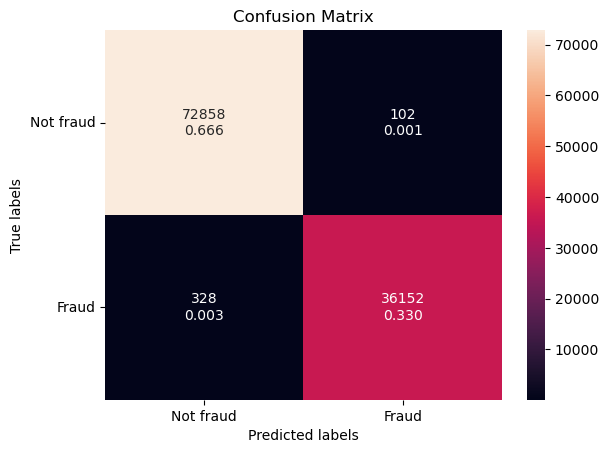

In [24]:
# SelectKBest

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_kbest = cross_val_predict(clf, X_train_kbest, y_train_smote, cv = sk_folds)

# Calculate scores
auc_kbest = roc_auc_score(y_train_smote, y_pred_kbest)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_kbest)}, precision: {precision_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_kbest, average='macro')}, f1: {f1_score(y_train_smote, y_pred_kbest, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_kbest, 2)}')

#Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_kbest)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9964364035087719, precision: 0.9963783438319879, recall: 0.9956003289473685, f1: 0.9959878145297825
AUC: 1.0


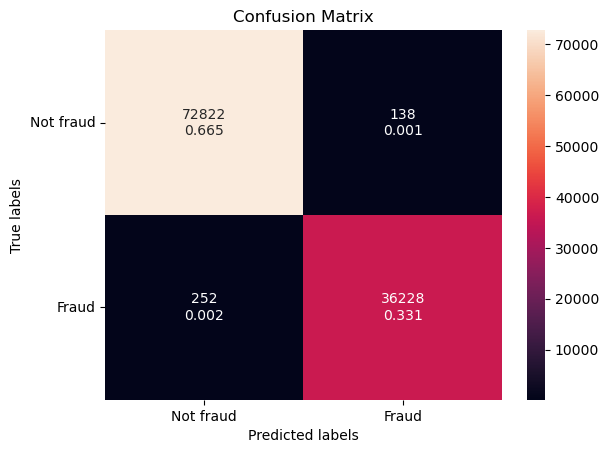

In [23]:
# Lasso

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso = cross_val_predict(clf, X_train_lasso, y_train_smote, cv = sk_folds)

# Run cross validation
auc_lasso = roc_auc_score(y_train_smote, y_pred_lasso)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso)}, precision: {precision_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_lasso, average='macro')}, f1: {f1_score(y_train_smote, y_pred_lasso, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_lasso, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_lasso)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9955774853801169, precision: 0.9960811819172555, recall: 0.9939692982456141, f1: 0.9950141026648907
AUC: 0.99


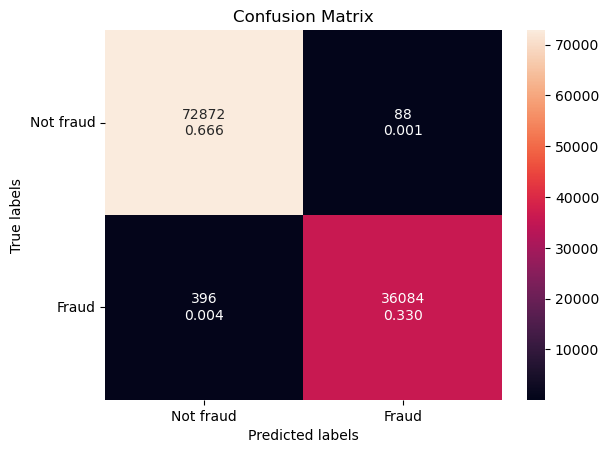

In [22]:
# RFECV

# Initiate model and stratified k folds
clf = RandomForestClassifier(max_depth=6, random_state=123)
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation
y_pred_rfecv = cross_val_predict(clf, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_rfecv = roc_auc_score(y_train_smote, y_pred_rfecv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_rfecv)}, precision: {precision_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_rfecv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_rfecv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_rfecv, 2)}')

# Plot confusion matrix
cm = confusion_matrix(y_train_smote, y_pred_rfecv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax= plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## With GridSearchCV

In [26]:
# Apply GridSearchCV on random forest with RFECV to tune hyperparameters
clf2 = RandomForestClassifier(random_state=123)

params = {'n_estimators': [100, 150, 150], 
         'max_features': ['sqrt', 'log2', 20],
         'max_depth': [10, 15],
         'criterion': ['gini', 'entropy']}
cv = GridSearchCV(estimator = clf2, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv.fit(X_train_rfecv, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  54.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  55.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  55.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  55.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=  55.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time= 1.2min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time= 1.3min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time= 1.3min
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=  34.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total t

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15],
                         'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [100, 150, 150]},
             scoring='f1', verbose=2)

In [28]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv.best_params_}')
cv_best_model = cv.best_estimator_

# Print top 10 most important features
importance= pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': cv_best_model.feature_importances_
})

print('\nTop 10 most important features:')
importance.sort_values(by='Importance', ascending=False)[:10]

Chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 20, 'n_estimators': 100}

Top 10 most important features:


,Feature,Importance
6,prev_trans_fraud,0.472281
7,count_fraud_prev10,0.245998
17,visited_cat,0.099392
9,merchant_prev_trans_fraud,0.063399
2,amt,0.038124
10,merchant_count_fraud_prev10,0.031734
3,hour,0.021467
19,amt_deviation,0.004671
14,interval,0.003119
13,hourly_risk_score,0.003115


accuracy: 0.9983826754385965, precision: 0.9983066892497644, recall: 0.9980537280701754, f1: 0.9981800481608615
AUC: 1.0


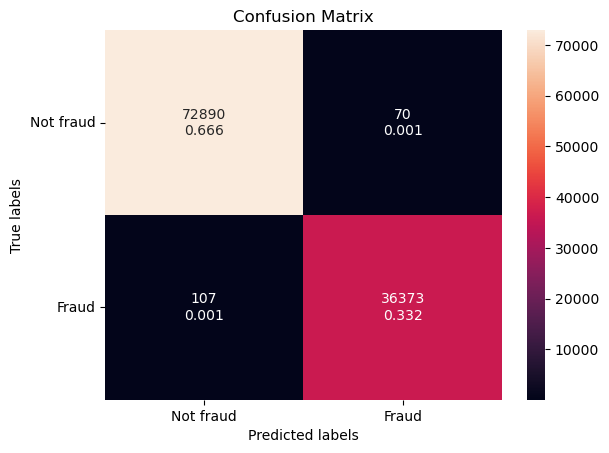

In [30]:
# Initiate stratified k folds
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)

# Run cross validation with chosen model
y_pred_gscv = cross_val_predict(cv_best_model, X_train_rfecv, y_train_smote, cv = sk_folds)

# Calculate scores
auc_gscv = roc_auc_score(y_train_smote, y_pred_gscv)
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_gscv)}, precision: {precision_score(y_train_smote, y_pred_gscv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_train_smote, y_pred_gscv, average='macro')}, f1: {f1_score(y_train_smote, y_pred_gscv, average='macro', zero_division = 0.0)}")
print(f'AUC: {round(auc_gscv, 2)}')

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_train_smote, y_pred_gscv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## XAI on test data (copy code structure only)

### Feature importance plot


Top 10 most important features:
                      Feature  Importance
6            prev_trans_fraud    0.611515
9   merchant_prev_trans_fraud    0.137395
17                visited_cat    0.082196
3                        hour    0.066686
13          hourly_risk_score    0.060085
7           count_fraud_7days    0.011760
2                         amt    0.010909
14                   interval    0.008637
8             acc_fraud_count    0.003568
26      category_shopping_net    0.002423


<Axes: xlabel='Importance', ylabel='Feature'>

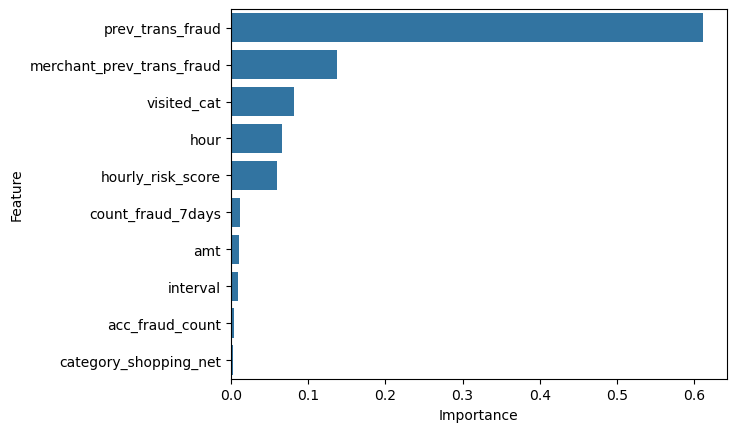

In [21]:
cv_best_model = RandomForestClassifier(criterion = 'entropy', max_depth = 15, max_features = 20, n_estimators = 100, random_state=123)
cv_best_model.fit(X_test_rfecv, y_test)

importance= pd.DataFrame({
    'Feature': X_test_rfecv.columns,
    'Importance': cv_best_model.feature_importances_
})

print('\nTop 10 most important features:')
print(importance.sort_values(by='Importance', ascending=False)[:10])

sns.barplot(data = importance.sort_values(by='Importance', ascending=False)[:10], x = 'Importance', y = 'Feature')


### SHAP

In [22]:
import shap

In [77]:
explainer = shap.Explainer(cv_best_model)
shap_values = explainer.shap_values(X_test_rfecv)

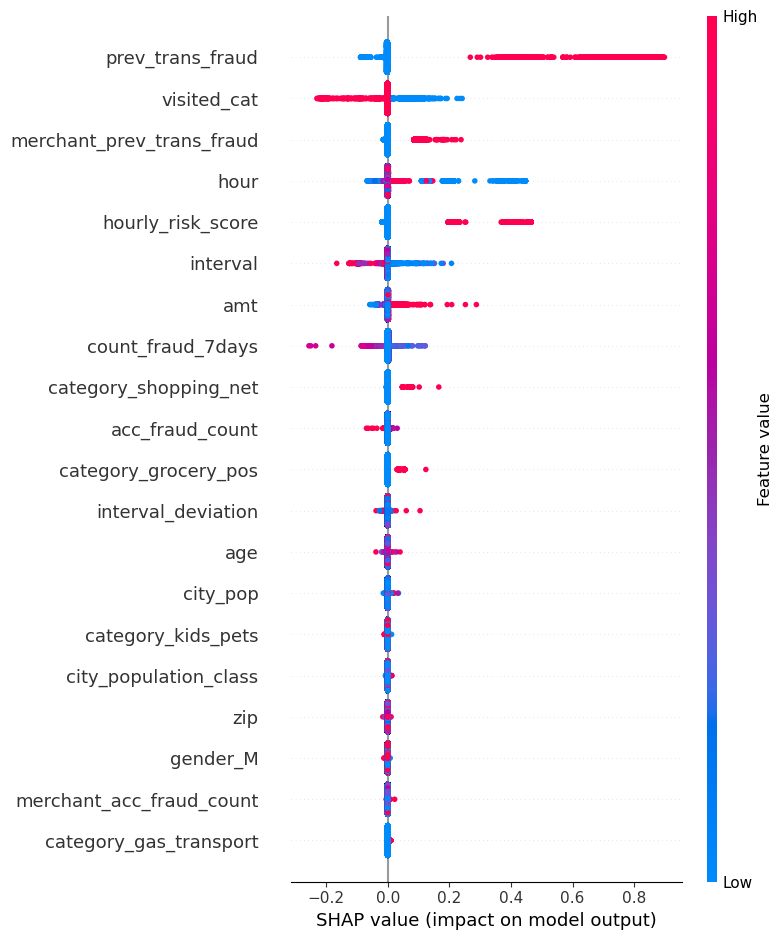

In [58]:
shap.summary_plot(shap_values[:,:, 1], X_test_rfecv)

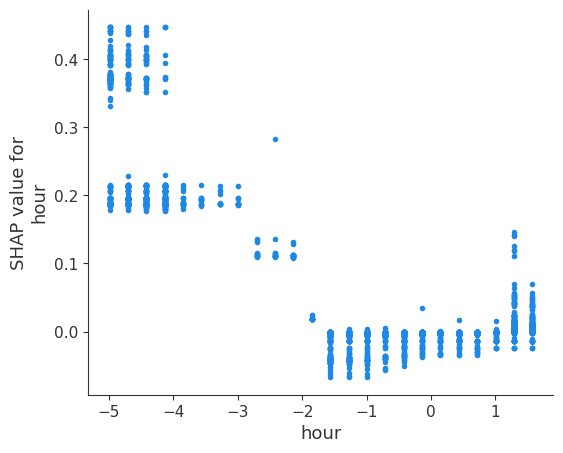

In [86]:
shap.dependence_plot("hour", shap_values[:,:,1], X_test_rfecv,interaction_index=None)


### Local example

Predicted value for row 1 of test data: 1
SHAP plot:


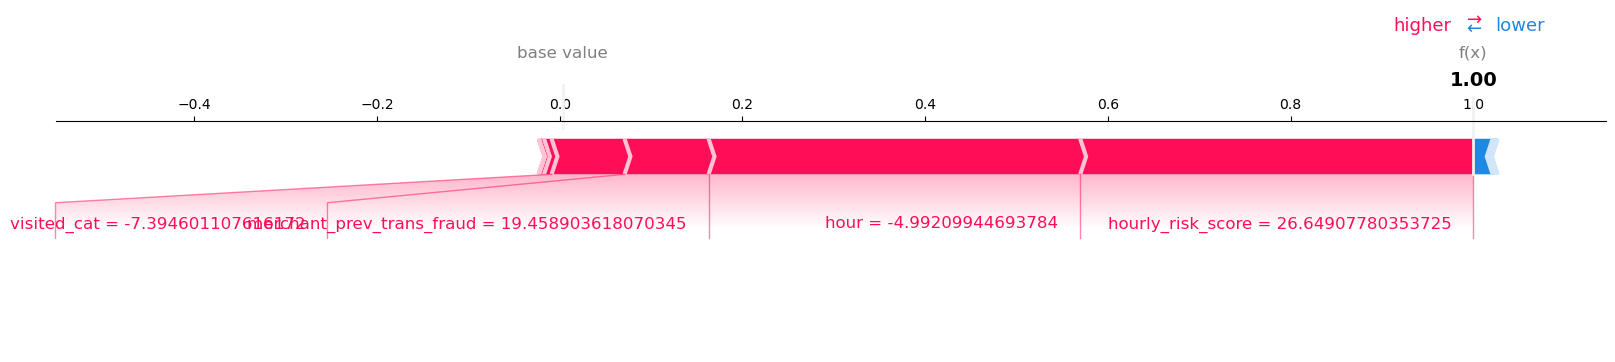

In [119]:
print(f'Predicted value for row 1 of test data: {cv_best_model.predict(X_test_rfecv.head(1))[0]}')
print('SHAP plot:')
shap.plots.force(explainer.expected_value[1], shap_values[:, :, 1][0,:], X_test_rfecv.iloc[0, :], matplotlib = True)

It appears that the biggest contributors were `hourly_risk_score`, `hour` and `prev_trans_fraud` 